# Inverse EIT

Now that we have successfully solved Poisson equation in a variety of domains we are ready to tackle the inverse problem, i.e given the current pattern $I$, electrode contact impedance vector $Z$, and measured electrode voltage vector $U^*$ we want to reconstruct the conductivity $\sigma$.


## Stage 1: Fitting the true electrode voltages

The first stage of the inverse problem is to reconstruct the electrode voltage vector $U = (U_l)_{l=1}^m$ corresponding to a fixed conductivity $\sigma: Q \rightarrow \mathbb{R}$, electrode impedance vector $Z = (Z_l)_{l=1}^m$ and current pattern $I = (I_l)_{l=1}^m$. We do this by minimizing the functional

$$ \mathcal{J}(U) =  \sum_{l=1}^m \left( \int_{E_l} \frac{U_l - u(x)}{Z_l}ds - I_l \right)^2 $$

in the control set 

$$ W = \{ U \in \mathbb{R}^m | \sum_{l=1}^m U_l = 0 \} $$

In [891]:
## Start with the 2D case, try to reproduce results in paper.
## Define problem data 

from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt

parameters["refinement_algorithm"] = "plaza_with_parent_facets"

tolerance = 0.001
num_electrodes = 16

alpha = 1.3*np.pi/num_electrodes
beta = 0.7*np.pi/num_electrodes

num_refinements = 1

domain = mshr.Circle(Point(0.,0.),0.1,100)
mesh = mshr.generate_mesh(domain, 50)

def cylindrical(x,y):
    r = np.sqrt(x**2 + y**2)
    if x>=0 and y>=0:
        theta = np.arccos(x/r)
    elif x<0 and y>=0:
        theta = np.arccos(x/r)
    elif x<0 and y<0:
        theta = np.pi - np.arcsin(y/r)
    elif x>=0 and y<0:
        theta = 2 * np.pi + np.arcsin(y/r)
        
    return r, theta


theta_limits = []
phi0 = 0

while phi0 < 2*np.pi-0.001:
    phi1 = phi0 + alpha
    theta_limits.append([phi0, phi1])
    phi0 = phi1 + beta

    
def is_electrode(x,y):
    r, theta = cylindrical(x,y)
    result = False
    if np.abs(r-domain.radius()) < tolerance:
        for electrode in theta_limits:
            phi0 = electrode[0]
            phi1 = electrode[1]
            
            if theta >= phi0 and theta <= phi1:
                result = True
                break
                
    return result
    
def which_electrode(x,y):
    m = len(theta_limits)
    
    r, theta = cylindrical(x,y)
    
    if is_electrode(x,y):
        l=0
        for j in range(len(theta_limits)):
            phi0 = theta_limits[j][0]
            phi1 = theta_limits[j][1]
            
            if theta >= phi0 and theta <= phi1:
                l = l+j
        return l
    else:
        return -1
                




U_start=[] # electrode voltages
Z=[] # electrode impedances
I = [-3, 2, 3, -7, 6, -1, -4, 2, 4, 3, -5, 4, 3, -5, 2, -4] # Current pattern

for i in range(len(theta_limits)):
    U_start.append(-0.1 * (-1)**i)
    Z.append(0.1)
    I[i] = I[i]/100
    
sigma_true = str("0.2 + 0.2 * ((pow(x[0],2) + pow(x[1]-0.05,2) < pow(0.03,2)) +"
                 + "(pow(x[0] + 0.075,2) + pow(x[1]+0.01,2) < pow(0.0063,2)) +"
                 + "(pow(x[0] + 0.015,2) + pow(x[1]+0.02,2) < pow(0.0122,2)) +"
                 + "(pow(x[0] - 0.025,2) + pow(x[1]+0.055,2) < pow(0.0235,2))) ")



In [892]:
theta_limits

[[0, 0.2552544031041707],
 [0.39269908169872414, 0.6479534848028948],
 [0.7853981633974483, 1.040652566501619],
 [1.1780972450961724, 1.4333516482003432],
 [1.5707963267948966, 1.8260507298990674],
 [1.9634954084936207, 2.2187498115977915],
 [2.356194490192345, 2.6114488932965156],
 [2.748893571891069, 3.00414797499524],
 [3.141592653589793, 3.396847056693964],
 [3.5342917352885173, 3.789546138392688],
 [3.9269908169872414, 4.182245220091412],
 [4.319689898685965, 4.5749443017901354],
 [4.712388980384689, 4.967643383488859],
 [5.1050880620834125, 5.360342465187583],
 [5.497787143782136, 5.7530415468863065],
 [5.89048622548086, 6.14574062858503]]

In [893]:
# Create electrodes

d = mesh.topology().dim()
electrodes = []


for l in range(num_electrodes):
    el = AutoSubDomain(lambda x: which_electrode(x[0], x[1]) == float(l))
    electrodes.append(el)


for i in range(num_refinements):
    r_markers = MeshFunction("bool", mesh, d-1, False)
    for l in range(num_electrodes):
        electrodes[l].mark(r_markers, True)
    RefinedMesh = refine(mesh, r_markers)
    mesh = RefinedMesh


boundary_markers = MeshFunction('size_t', mesh, d-1)

for l in range(num_electrodes):
    electrodes[l].mark(boundary_markers, l+1)

ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

V = FunctionSpace(mesh, "Lagrange", 2)
sigma = interpolate(Expression(sigma_true, degree=0), V)



In [894]:
# Perform integrals with trapezoidal rule for better performance

from scipy import integrate

def integrate_electrode(func, l, points=200):
    eps = 0.0001
    r = domain.radius() - eps
    phi_values = np.linspace(theta_limits[l][0], theta_limits[l][1], points)
    f_values = []
    
    for phi in phi_values:
        f_values.append(r * func(r * np.cos(phi), r * np.sin(phi)))

    return integrate.trapz(f_values, phi_values)

# Define necessary functions

def J(solution, U):
    result = 0.0
    for l in range(num_electrodes):
        result += ((1/Z[l])* integrate_electrode(lambda x,y: U[l] - solution(x,y), l) - I[l] )**2
    return result

def potential(sigma, U):
    
    u = TrialFunction(V)
    v = TestFunction(V)
    
    a = inner(nabla_grad(u), nabla_grad(v))*sigma*dx
    L = 0
    
    for l in range(num_electrodes):
        a = a + u*v*(1/Z[l])*ds(l+1)
        L = L + v*(U[l]/Z[l])*ds(l+1)

    u = Function(V)
    solve(a==L, u, solver_parameters={'linear_solver': 'umfpack',
                         'preconditioner': 'icc'})
    
    return u

def adjoint(sigma, U, solution, I=I):
    psi = TrialFunction(V)
    v = TestFunction(V)
    
    a = inner(nabla_grad(psi), nabla_grad(v))*sigma*dx
    L = 0
    
    for l in range(num_electrodes):
        a = a + psi*v*(1/Z[l])*ds(l+1)
        #L = L + v *(1/Z[l]) *  ( 2.0 * assemble((solution - U[l])*(1/Z[l])*ds(l+1)) + 2*I[l]   )*ds(l+1)
        L = L + v * (1/Z[l]) * (2 * integrate_electrode(lambda x, y: 
                                                     (solution(x,y) - U[l])/Z[l], l) + 2*I[l]) *ds(l+1)

    psi = Function(V)
    solve(a==L, psi, solver_parameters={'linear_solver': 'umfpack',
                         'preconditioner': 'icc'})
    
    return psi

def magnitude(vector):
    result = 0
    for i in range(len(vector)):
        result += vector[i]**2
    result = np.sqrt(result)
    return result

def subtract(vec1, vec2):
    result = []
    if len(vec1)==len(vec2):
        for i in range(len(vec1)):
            result.append(vec1[i] - vec2[i])
        return result
    else:
        print("Vectors must be the same length!")
        
def dot(vec1, vec2):
    result = 0
    if len(vec1) == len(vec2):
        for i in range(len(vec1)):
            result += vec1[i] * vec2[i]
        return result
    else:
        print("Vectors must be the same length!")

w = []
e = np.eye(num_electrodes)
for k in range(num_electrodes):
    w.append(potential(sigma, e[k]))

def grad_U(solution, U):
    result = []
    
    for k in range(num_electrodes):
        k_entry = 0
        for l in range(num_electrodes):
            k_entry += 2 * (integrate_electrode(lambda x,y: (U[l] - solution(x,y))/Z[l],
                                          l, points=10) - I[l]) * integrate_electrode(lambda x,y:
                                              ((l==k) - w[k](x,y))/Z[l], l, points = 10)
        result.append(k_entry)   
    return result

def new_learning_rate(tau, sigma, U_N, U_N_minus_one, u_N, u_N_minus_one):
    J_N = J(u_N, U_N)
    dU = subtract(U_N, U_N_minus_one)
    grad_N = grad_U(u_N, U_N)
    grad_N_minus_one = grad_U(u_N_minus_one, U_N_minus_one)
    
    delta_grad_U = subtract(grad_N, grad_N_minus_one)
    
    alpha_new = dot(dU, dU)/ dot(dU, delta_grad_U)
    
#    U_new = []
#    for k in range(num_electrodes):
#        U_new.append(U_N[k] - alpha_new * grad_N[k])
    
#    U_sum = sum(U_new)
#    for k in range(num_electrodes):
#        U_new[k] -= U_sum/ num_electrodes
    
#    u_new = potential(sigma, U_new)
    
#    J_new = J(u_new, U_new)
    
#    while J_N < J_new:
#        alpha_new = tau * alpha_new
#        U_new = []
#        for k in range(num_electrodes):
#            U_new.append(U_N[k] - alpha_new * grad_N[k])
    
#        U_sum = sum(U_new)
#        for k in range(num_electrodes):
#            U_new[k] -= U_sum/ num_electrodes
    
#    u_new = potential(sigma, U_new)
    
#        J_new = J(u_new, U_new)
#    J_opt = 0
#    alpha_opt = alpha_new
    
#    while J_opt < J_new:
#        alpha_opt = 1.1 * alpha_opt
        
#        U_opt = []
#        for k in range(num_electrodes):
#            U_opt.append(U_N[k] - alpha_opt * grad_N[k])
    
#            U_sum = sum(U_opt)
#        for k in range(num_electrodes):
#            U_opt[k] -= U_sum/ num_electrodes
    
#        u_opt = potential(sigma, U_opt)
    
#        J_opt = J(u_opt, U_opt)
        
#        if J_opt < J_new:
#            alpha_new = alpha_opt
            
    return alpha_new
    
    
            
        



In [941]:
mesh.num_cells()

10116

In [895]:
# Main code for stage 1

N = 0
Nmax = 20 # max number of iterations
epsilon = 1e-6 # stopping parameter
starting_learning_rate = 30
tau = 0.8


e = np.eye(num_electrodes)
w = []
U_history = []
J_history = []

U_N = []

for k in range(num_electrodes):
    w.append(potential(sigma, e[k]))
    U_N.append(U_start[k])

alpha_N = starting_learning_rate

while N < Nmax:
    
    print("Iteration ", N)
    
    # step 2
    u_N = potential(sigma, U_N)
    J_N = J(u_N, U_N)
    
    J_history.append(J_N)
    U_history.append(np.array(U_N))
    
    print("step 2 done")
    
    if N > 0:
        # Step 3
        u_N_minus_one = potential(sigma, U_N_minus_one)
        alpha_N = new_learning_rate(tau, sigma, U_N, U_N_minus_one, u_N, u_N_minus_one)
        J_step = abs(J_N - J_N_minus_one)/J_N_minus_one
        U_step = magnitude(subtract(U_N, U_N_minus_one))/magnitude(U_N_minus_one)
        
        if J_step < epsilon or U_step < epsilon:
            print("Done!")
            break
        
        print("step 3 done")
        
    
    # step 6
    
    U_N_plus_one = [0]*num_electrodes

    
    
#    if N > 0 and J_N > J_N_minus_one:
#        alpha_N = alpha_N/2
#    elif N > 0:
#        alpha_N = 1.1 * alpha_N
    
    

    for k in range(num_electrodes):
        U_N_plus_one[k] = U_N[k]
    
        for l in range(num_electrodes):
            U_N_plus_one[k] -=  alpha_N * 2 * (integrate_electrode(lambda x,y: (1/Z[l]) * (U_N[l] 
                                - u_N(x, y)), l) - I[l]) * integrate_electrode(lambda x,y:
                                   (1/Z[l]) * ((l==k) - w[k](x,y)), l)
    print("step 6 done")
    
    U_sum = sum(U_N_plus_one)

    for k in range(num_electrodes):
        U_N_plus_one[k] = U_N_plus_one[k] - (1/num_electrodes) * U_sum

    print("step 7 done")
    
    U_N_minus_one = [0]*num_electrodes
    
    for l in range(num_electrodes):
        U_N_minus_one[l] = U_N[l]
        U_N[l] = U_N_plus_one[l]
    J_N_minus_one = J_N
    
    N += 1
    
    print("##############")
    print("              ")
    

u_N = potential(sigma, U_N)
J_N = J(u_N, U_N)
    
J_history.append(J_N)
U_history.append(np.array(U_N))
    
    
    



        






Iteration  0
step 2 done
step 6 done
step 7 done
##############
              
Iteration  1
            Calling FFC just-in-time (JIT) compiler, this may take some time.
step 2 done
step 3 done
step 6 done
step 7 done
##############
              
Iteration  2
            Calling FFC just-in-time (JIT) compiler, this may take some time.
step 2 done
step 3 done
step 6 done
step 7 done
##############
              
Iteration  3
            Calling FFC just-in-time (JIT) compiler, this may take some time.
step 2 done
step 3 done
step 6 done
step 7 done
##############
              
Iteration  4
            Calling FFC just-in-time (JIT) compiler, this may take some time.
step 2 done
step 3 done
step 6 done
step 7 done
##############
              
Iteration  5
            Calling FFC just-in-time (JIT) compiler, this may take some time.
step 2 done
step 3 done
step 6 done
step 7 done
##############
              
Iteration  6
            Calling FFC just-in-time (JIT) compiler, this may t

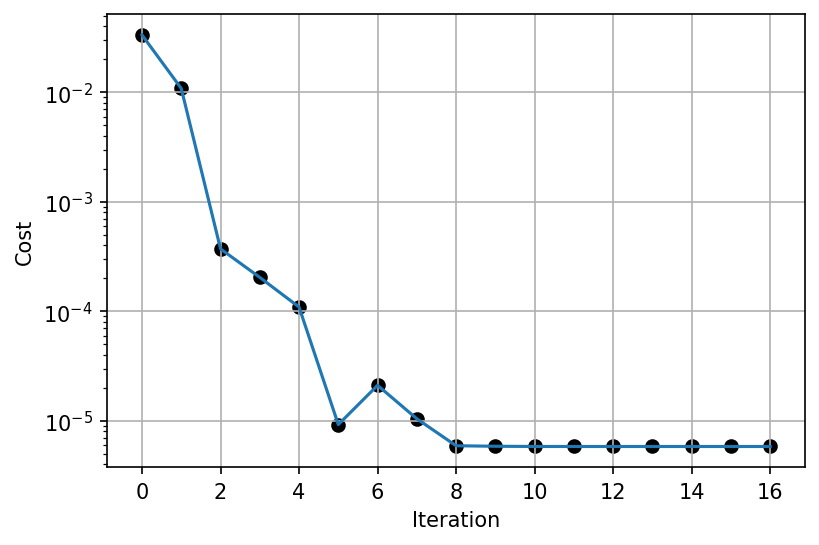

In [964]:
plt.plot(range(len(J_history)), J_history)
plt.scatter(range(len(J_history)), J_history, c='k')
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.yscale("log")
plt.grid()
plt.savefig("S1Cost.jpg")

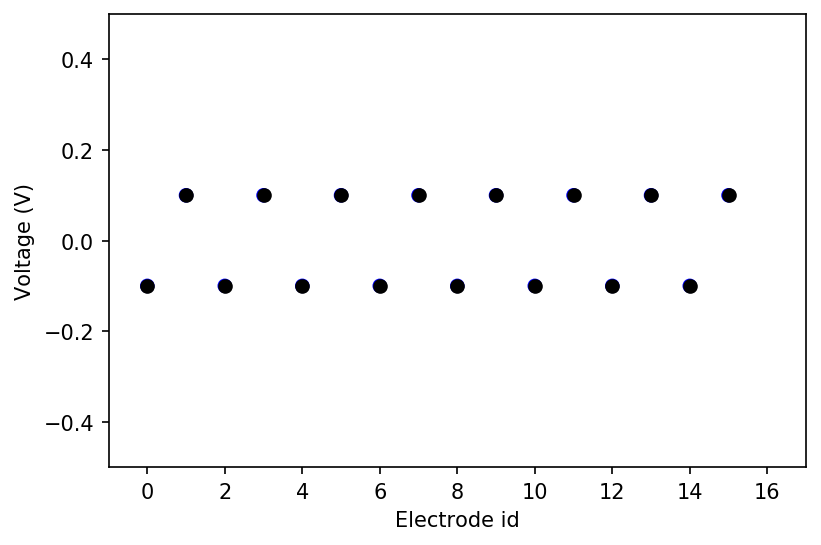

In [897]:
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

x = range(0, num_electrodes)
def animate(t):
    plt.cla()
    plt.scatter(x, U_history[t], facecolors='none', edgecolors='b')
    plt.scatter(x, U_start, color='k')
    plt.xlim(-1,num_electrodes + 1)
    plt.ylim(-0.5,0.5)
    
    plt.xlabel("Electrode id")
    plt.ylabel("Voltage (V)")
    

matplotlib.animation.FuncAnimation(fig, animate, interval = 1000, frames=len(J_history))


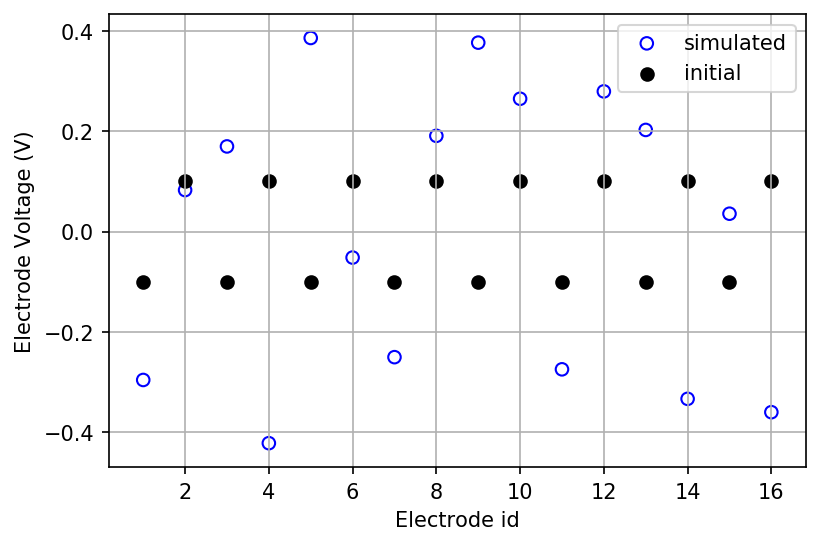

In [959]:
x = np.arange(1,num_electrodes+1)
plt.scatter(x, U_star, facecolors='none', edgecolors='b', label="simulated")
plt.scatter(x, U_start, color='k', label="initial")
plt.xlabel("Electrode id")
plt.ylabel("Electrode Voltage (V)")
plt.legend()
plt.grid()
plt.savefig("S1U.png")

## Stage 2

The second stage of the problem is to approximate the conductivity using the $m$ data-points $U^*$, that is minimizing the functional

$$ \mathcal{J}(\sigma, U) = \sum_{l=1}^m \left( \int_{E_l} \frac{U_l[\sigma] - u[\sigma]}{Z_l} ds - I_l \right)^2 + \beta |U[\sigma]-U^*|^2 $$

In [985]:
beta = 0.3162
U_star = U_history[-1]

def J(solution, U):
    result = 0.0
    for l in range(num_electrodes):
        result += ((1/Z[l])* integrate_electrode(lambda x,y: U[l] - solution(x,y), l) - I[l] )**2
    return result + beta * magnitude(subtract(U, U_star))**2

def L2_norm(V_function):
    return np.sqrt(assemble(V_function**2 * dx))

def grad_J(w, psi, u, U):
    result = list(-project(inner(nabla_grad(u), nabla_grad(psi)), V).vector()[:])
    for k in range(num_electrodes):
        k_entry = 0
        for l in range(num_electrodes):
            k_entry += 2 * (integrate_electrode(lambda x,y:
                     (U[l]-u(x,y))/Z[l], l, points=10) - I[l])*integrate_electrode(lambda x,y:
                      ((l==k) - w[k](x,y)), l, points=10)*(1/Z[l]) + 2*beta*(U[k] - U_star[k])
        result.append(k_entry)
    return result

def BBL_learning_rate(sigma_N, sigma_N_minus_one, U_N,
                      U_N_minus_one, grad_J_N, grad_J_N_minus_one):
    delta_U = subtract(U_N, U_N_minus_one)
    delta_sigma = list(project(sigma_N - sigma_N_minus_one, V).vector()[:])
    delta_grad_J = subtract(grad_J_N, grad_J_N_minus_one)
    delta_x = delta_sigma + delta_U
    
    alpha_long = dot(delta_x, delta_x) / dot(delta_x, delta_grad_J)
    
    return abs(alpha_long)

def BBS_learning_rate(sigma_N, sigma_N_minus_one, U_N,
                     U_N_minus_one, grad_J_N, grad_J_N_minus_one):
    
    delta_U = subtract(U_N, U_N_minus_one)
    delta_sigma = list(project(sigma_N - sigma_N_minus_one, V).vector()[:])
    delta_grad_J = subtract(grad_J_N, grad_J_N_minus_one)
    delta_x = delta_sigma + delta_U
    
    alpha_short = dot(delta_x, delta_grad_J) / dot (delta_grad_J, delta_grad_J)
    
    return abs(alpha_short)
    
    
    
    

In [986]:
e_area = 0
total_area = 2*np.pi*0.1

for l in range(num_electrodes):
    e_area += integrate_electrode(lambda x,y: 1, l)
percent = e_area * 100 / total_area
print(percent)
   

64.935


In [987]:
# Main code for stage 2

N = 0
Nmax = 20 # max number of iterations
epsilon = 1e-6 # stopping parameter
starting_learning_rate = 0.5
tau = 0.8

J_history2 = []
U_history2 = []


e = np.eye(num_electrodes)

U_N = []
sigma_N = interpolate(Constant(0.3), V)

for k in range(num_electrodes):
    #w.append(potential(sigma, e[k]))
    U_N.append(U_star[k])

alpha_N = starting_learning_rate

J_best = 1
sigma_best = sigma_N


while N < Nmax:
    
    w_N = []
    
    print("Iteration ", N)
    
    # step 2
    u_N = potential(sigma_N, U_N)
    J_N = J(u_N, U_N)
    
    J_history2.append(J_N)
    U_history2.append(np.array(U_N))
    
    print("step 2 done")
    
    if N > 0:
        # Step 3
        #u_N_minus_one = potential(sigma, U_N_minus_one)
        #alpha_N = new_learning_rate(tau, sigma, U_N, U_N_minus_one, u_N, u_N_minus_one)
        J_step = abs(J_N - J_N_minus_one)/J_N_minus_one
        U_step = magnitude(subtract(U_N, U_N_minus_one))/magnitude(U_N_minus_one)
        sigma_step = L2_norm(sigma_N - sigma_N_minus_one)/L2_norm(sigma_N_minus_one)
        
        if J_step < epsilon or U_step < epsilon or sigma_step < epsilon:
            break
        
        print("step 3 done")
        
    # step 4
    
    for k in range(num_electrodes):
        w_N.append(potential(sigma_N, e[k]))
    
    print("step 4 done")
    
    # step 5
    
    psi_N = adjoint(sigma_N, U_N, u_N)
    
    print("step 5 done")
    

    if N>0:
        grad_J_N = grad_J(w_N, psi_N, u_N, U_N)
        grad_J_N_minus_one = grad_J(w_N_minus_one,
                                    psi_N_minus_one, u_N_minus_one, U_N_minus_one)
        
        alpha_N = BBS_learning_rate(sigma_N, sigma_N_minus_one, U_N,
                      U_N_minus_one, grad_J_N, grad_J_N_minus_one)
        
    
    # step 6
    
    U_N_plus_one = [0]*num_electrodes

    
    

#    if N > 0 and J_N > J_N_minus_one:
#        alpha_N = alpha_N / 1.5
#    elif N > 0 and J_N_minus_one > J_N:
#        alpha_N = 1.1 * alpha_N

    
    
    

    for k in range(num_electrodes):
        U_N_plus_one[k] = U_N[k] - 2 * alpha_N * beta * (U_N[k] - U_star[k])
    
        for l in range(num_electrodes):
            U_N_plus_one[k] -=  alpha_N * 2 * (integrate_electrode(lambda x,y: (1/Z[l]) * (U_N[l] 
                                - u_N(x, y)), l) - I[l]) * integrate_electrode(lambda x,y:
                                   (1/Z[l]) * ((l==k) - w_N[k](x,y)), l)
            
    sigma_N_plus_one = sigma_N + alpha_N * inner(nabla_grad(psi_N), nabla_grad(u_N))
    sigma_N_plus_one = project(sigma_N_plus_one, V)
    
    print("step 6 done")
    
    U_sum = sum(U_N_plus_one)

    for k in range(num_electrodes):
        U_N_plus_one[k] = U_N_plus_one[k] - (1/num_electrodes) * U_sum
        
    x = sigma_N_plus_one.vector()[:]
    x[x>0.4] = 0.4
    x[x<0.2] = 0.2
    sigma_N_plus_one.vector()[:] = x

    print("step 7 done")
    
    if J_N < J_best:
        J_best = J_N
        sigma_best = sigma_N
    
    U_N_minus_one = [0]*num_electrodes
    
    for l in range(num_electrodes):
        U_N_minus_one[l] = U_N[l]
        U_N[l] = U_N_plus_one[l]
    
    J_N_minus_one = J_N
    sigma_N_minus_one = sigma_N
    sigma_N = sigma_N_plus_one
    
    u_N_minus_one = u_N
    w_N_minus_one = []
    for k in range(num_electrodes):
        w_N_minus_one.append(w_N[k])
    psi_N_minus_one = psi_N
        
    
    N += 1
    
    print("##############")
    print("              ")
    

u_N = potential(sigma_N, U_N)
J_N = J(u_N, U_N)

Iteration  0
step 2 done
step 4 done
                Calling FFC just-in-time (JIT) compiler, this may take some time.
step 5 done
step 6 done
step 7 done
##############
              
Iteration  1
                Calling FFC just-in-time (JIT) compiler, this may take some time.
step 2 done
step 3 done
step 4 done
                Calling FFC just-in-time (JIT) compiler, this may take some time.
step 5 done
                Calling FFC just-in-time (JIT) compiler, this may take some time.
step 6 done
step 7 done
##############
              
Iteration  2
                Calling FFC just-in-time (JIT) compiler, this may take some time.
step 2 done
step 3 done
step 4 done
                Calling FFC just-in-time (JIT) compiler, this may take some time.
step 5 done
                Calling FFC just-in-time (JIT) compiler, this may take some time.
step 6 done
step 7 done
##############
              
Iteration  3
                Calling FFC just-in-time (JIT) compiler, this may take some time

In [919]:
U_history[-1]

array([-0.29646159,  0.08286353,  0.17007027, -0.4227209 ,  0.38666838,
       -0.05192787, -0.25089823,  0.19122009,  0.37738405,  0.26530032,
       -0.27520243,  0.27999775,  0.20299696, -0.3341377 ,  0.03565425,
       -0.36080687])

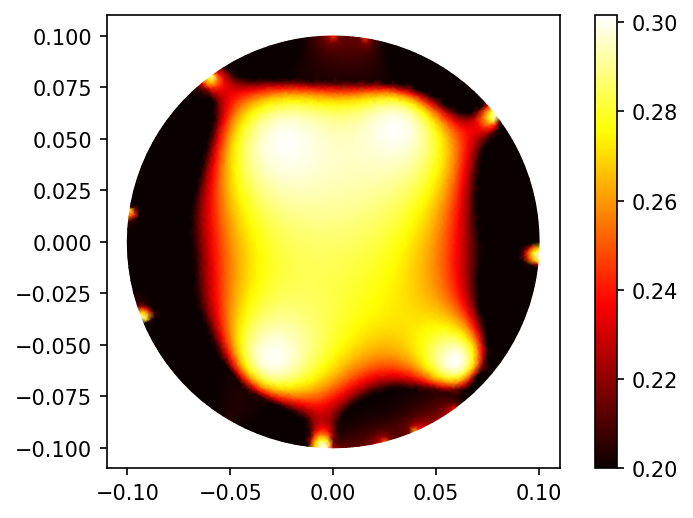

In [990]:
p = plot(sigma_best, mode = "color", cmap = 'hot')
plt.colorbar(p)
plt.savefig("S2sigma.png")

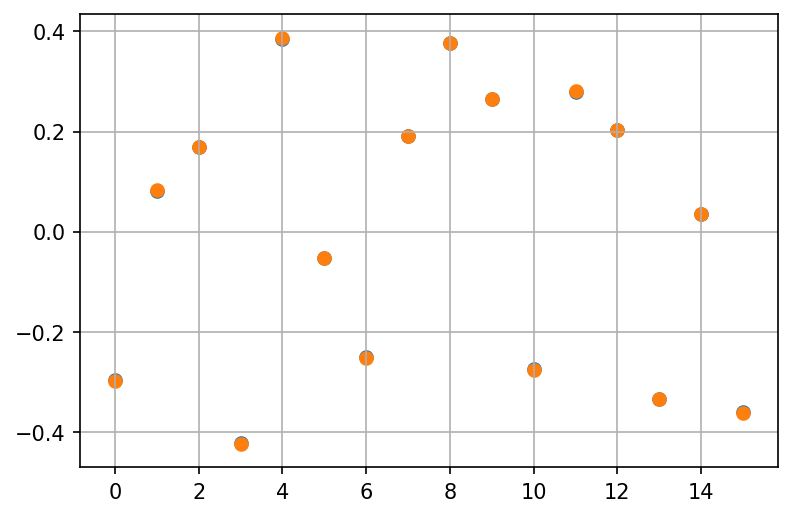

In [991]:
plt.scatter(range(num_electrodes), U_N_minus_one)
plt.scatter(range(num_electrodes),U_star)
plt.grid(True)

## Stage 3: Augmenting electrode data 

Finally, we move on to step 3. Here, we first rotate the electrode voltages $U$ $m$ times to generate $m$ voltage vectors $U^1 = (U_1, \cdots, U_m)$, $U^2 = (U_m, U_1, \cdots, U_{m-1})$, solve the forward PDE problem for $(u^j)_{j=1}^m$, and use the voltage-to-current formula

$$ I^j_l = \int_{E_l}\sigma(x)\frac{\partial u^j}{\partial n} ds $$

to calculate the corresponding current pattern. Note that the conductivity used to solve the PDE and in the above formula should be the true conductivity, as the resulting current pattern is measured directly in clinical applications. Then, we repeat the same gradient descent as in stage 2 for the functional

$$ \mathcal{K}[\sigma, U] = \sum_{j=1}^m \sum_{l=1}^m \left(  \int \frac{U_l^j - u^j (x)}{Z_l} ds - I_l^j \right)^2 + \beta|U-U^*|^2 . $$

In [900]:

def n(x,y):
    result = []
    result.append(x/magnitude([x,y]))
    result.append(y/magnitude([x,y]))
    
    return(result)

def get_U_j(U):
    result = []
    
    for j in range(num_electrodes):
        j_entry = []
        for k in range(num_electrodes):
            j_entry.append(U[k-j])
        result.append(j_entry)
    return result


def get_I_j(U):
    current= []
    u_j = potential(sigma, U)
    
    #dudx = project(nabla_grad(u_j)[0], V)
    #dudy = project(nabla_grad(u_j)[1], V)
    
    
    for l in range(num_electrodes):
        integral = integrate_electrode(lambda x,y: (U[l] - u_j(x,y))/Z[l], l, points=500)
        current.append(integral)
    current = np.array(current) - sum(current)/num_electrodes
    return np.array(current)

def get_u_j(s, U_j):
    result = []
    
    for j in range(num_electrodes):
        result.append(potential(s, U_j[j]))

    return result

def get_psi_j(sigma, U_j, u_j, I_j):
    result = []
    
    for j in range(num_electrodes):
        result.append(adjoint(sigma, U_j[j], u_j[j], I=I_j[j]))

    return result

I_j = []

for j in range(num_electrodes):
    I_j.append(get_I_j(get_U_j(U_star)[j]))


        
    
    

            Calling FFC just-in-time (JIT) compiler, this may take some time.
            Calling FFC just-in-time (JIT) compiler, this may take some time.
            Calling FFC just-in-time (JIT) compiler, this may take some time.
            Calling FFC just-in-time (JIT) compiler, this may take some time.
            Calling FFC just-in-time (JIT) compiler, this may take some time.
            Calling FFC just-in-time (JIT) compiler, this may take some time.
            Calling FFC just-in-time (JIT) compiler, this may take some time.
            Calling FFC just-in-time (JIT) compiler, this may take some time.
            Calling FFC just-in-time (JIT) compiler, this may take some time.
            Calling FFC just-in-time (JIT) compiler, this may take some time.
            Calling FFC just-in-time (JIT) compiler, this may take some time.
            Calling FFC just-in-time (JIT) compiler, this may take some time.
            Calling FFC just-in-time (JIT) compiler, this may ta

In [901]:
sum(I_j[0])

6.9388939039072284e-18

In [935]:
beta = 0.3162
def K(sol_j, U_j ):
    
    result = beta * magnitude(subtract(U_j[0], U_star))**2
    
    for j in range(num_electrodes):
        for l in range(num_electrodes):
            result += (integrate_electrode(lambda x,y: (1/Z[l]) * (
                U_j[j][l] - sol_j[j](x,y)), l) - I_j[j][l] )**2
    return result

def theta_kj(k,j):
    if j<=k:
        result = k-j
    else:
        result = num_electrodes + k - j

    return int(result)

def grad_K(w, psi_j, u_j, U_j, I_j):
    
    sigma_entry = 0
    
    for j in range(num_electrodes):
        sigma_entry -= inner(nabla_grad(psi_j[j]), nabla_grad(u_j[j]))
    
    result = list(project(sigma_entry, V).vector()[:])
    
    for k in range(num_electrodes):
        k_entry = 0
        
        for j in range(num_electrodes):
            for l in range(num_electrodes):
                k_entry += 2 * (integrate_electrode(lambda x,y:
                     (U_j[j][l]-u_j[j](x,y))/Z[l], l, points=10) - I_j[j][l])*integrate_electrode(lambda x,y:
                      ((l==k) - w[theta_kj(k,j)](x,y)), l, points=10)*(1/Z[l]) + 2*beta*(U_j[0][k] - U_star[k])
        result.append(k_entry) 
    return result

def BBS_learning_rate(sigma_N, sigma_N_minus_one, U_N,
                     U_N_minus_one, grad_K_N, grad_K_N_minus_one):
    
    delta_U = subtract(U_N, U_N_minus_one)
    delta_sigma = list(project(sigma_N - sigma_N_minus_one, V).vector()[:])
    delta_grad_K = subtract(grad_K_N, grad_K_N_minus_one)
    delta_x = delta_sigma + delta_U
    
    alpha_short = dot(delta_x, delta_grad_K) / dot (delta_grad_K, delta_grad_K)
    
    return abs(alpha_short)

def BBL_learning_rate(sigma_N, sigma_N_minus_one, U_N,
                     U_N_minus_one, grad_K_N, grad_K_N_minus_one):
    
    delta_U = subtract(U_N, U_N_minus_one)
    delta_sigma = list(project(sigma_N - sigma_N_minus_one, V).vector()[:])
    delta_grad_K = subtract(grad_K_N, grad_K_N_minus_one)
    delta_x = delta_sigma + delta_U
    
    alpha_long = dot(delta_x, delta_x) / dot (delta_x, delta_grad_K)
    
    return abs(alpha_long)

    

Iteration  0
step 2 done
step 3 done
step 4 done
step 5 done
step 6 done
step 7 done


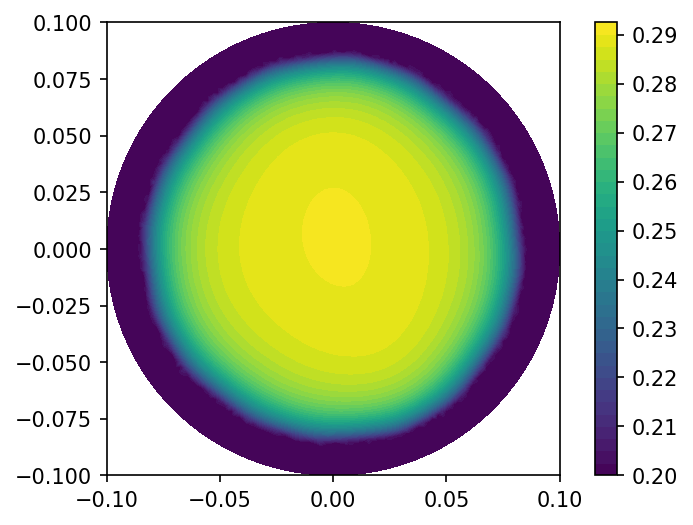

##############
              
Iteration  1
step 2 done
step 3 done
step 4 done
step 5 done
                Calling FFC just-in-time (JIT) compiler, this may take some time.
step 6 done
step 7 done


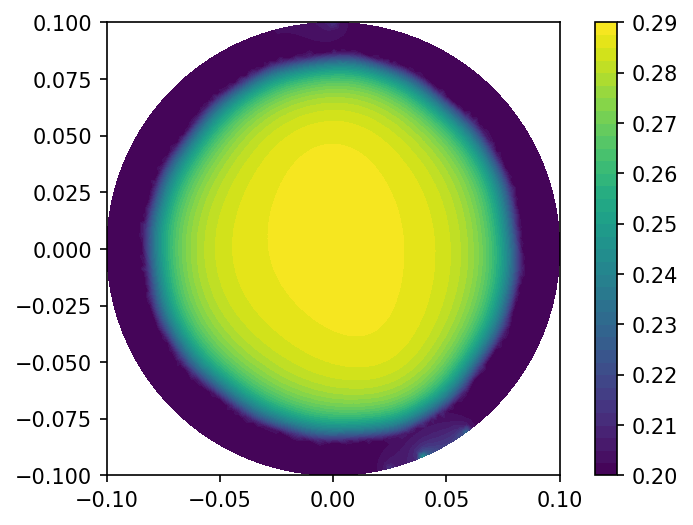

##############
              
Iteration  2
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler

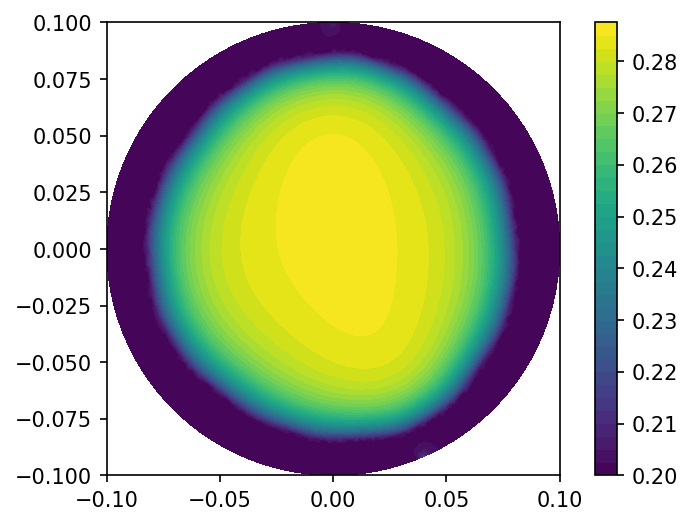

##############
              
Iteration  3
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler

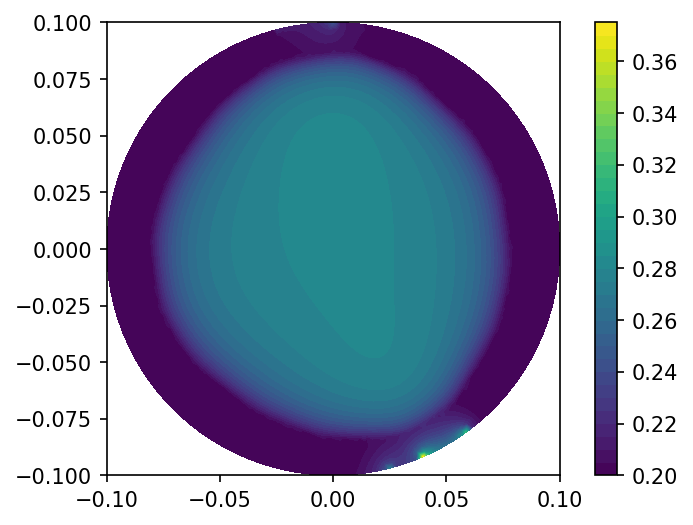

##############
              
Iteration  4
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler

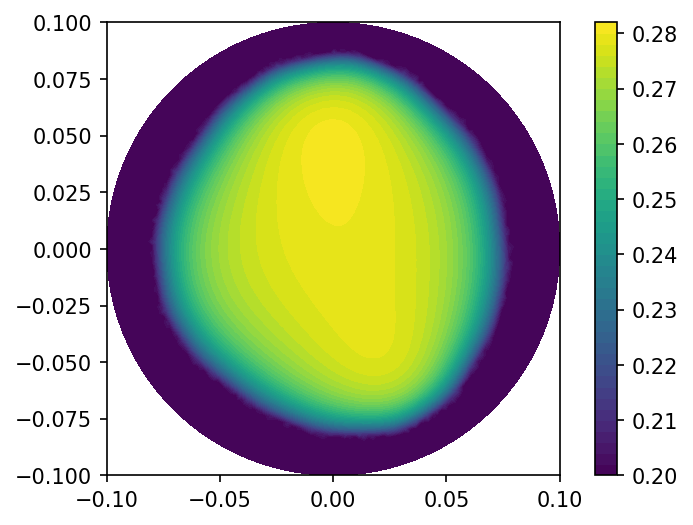

##############
              
Iteration  5
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler

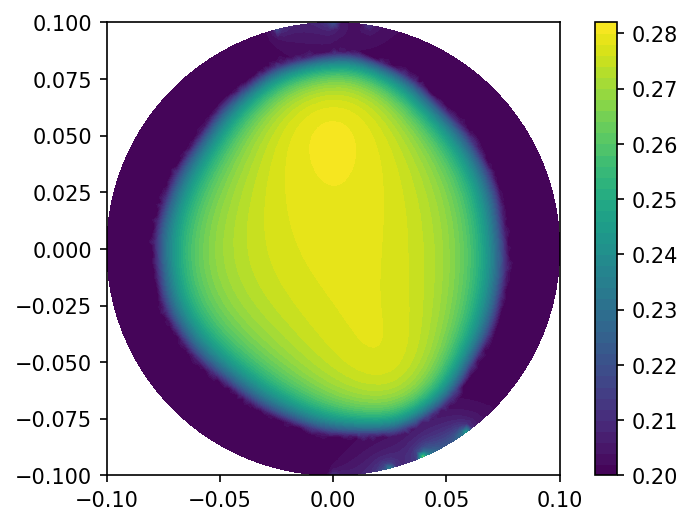

##############
              
Iteration  6
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler

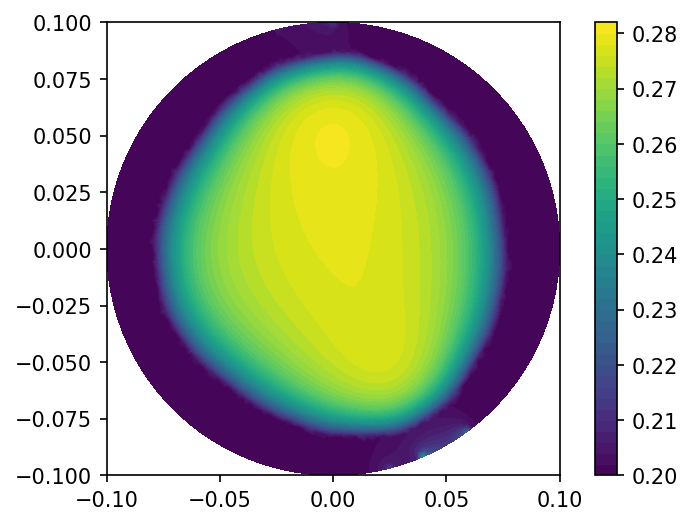

##############
              
Iteration  7
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler

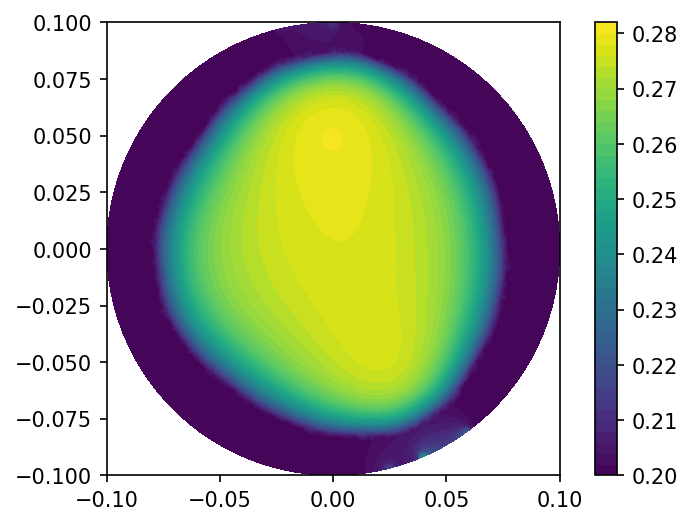

##############
              
Iteration  8
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler

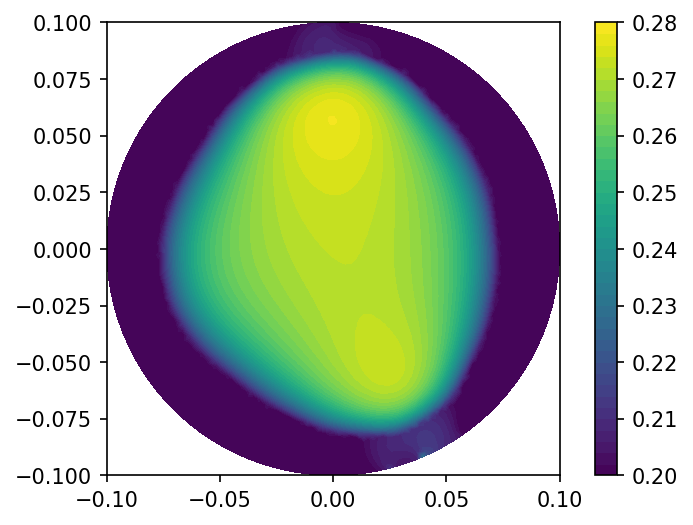

##############
              
Iteration  9
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler

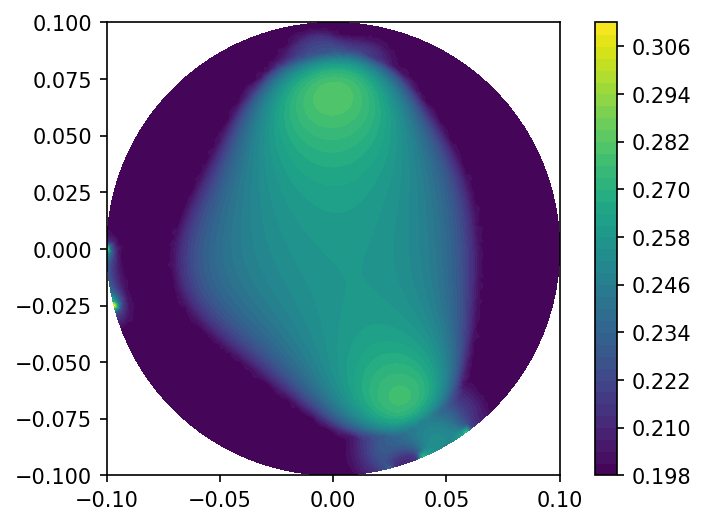

##############
              
Iteration  10
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

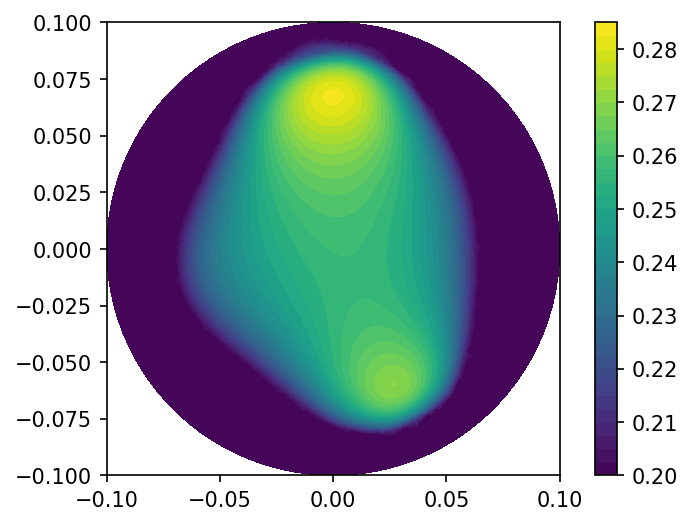

##############
              
Iteration  11
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

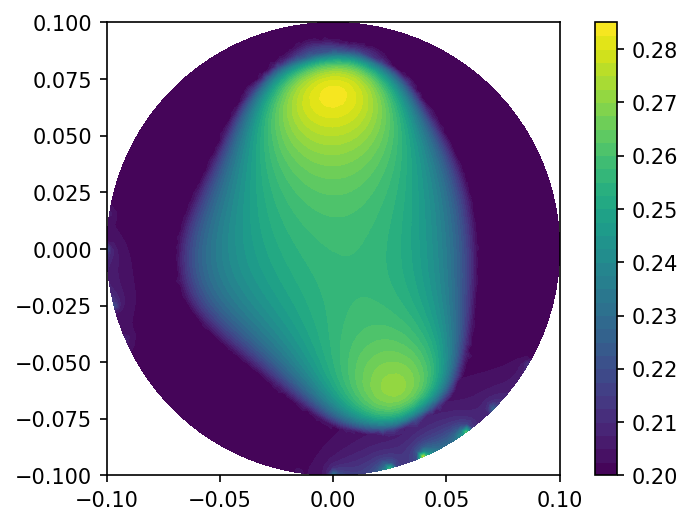

##############
              
Iteration  12
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

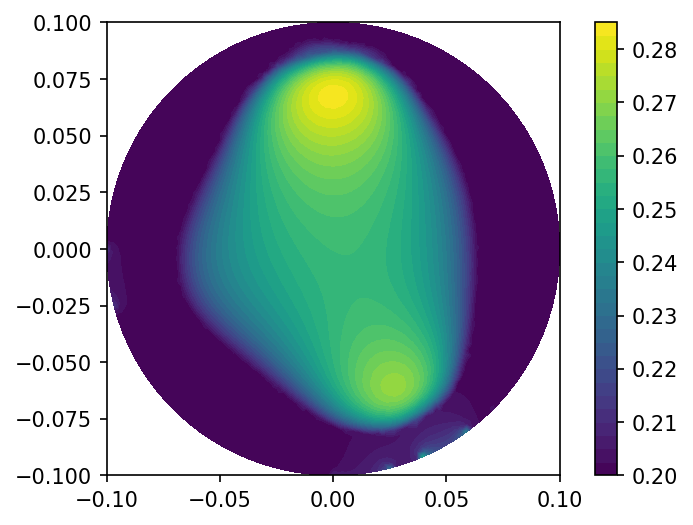

##############
              
Iteration  13
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

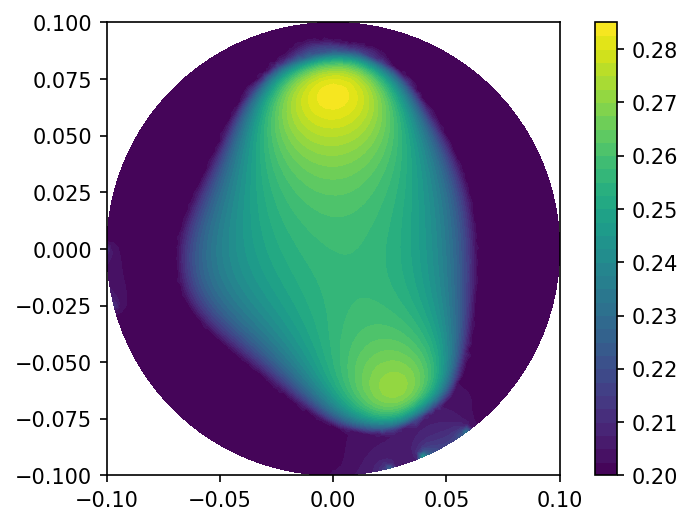

##############
              
Iteration  14
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

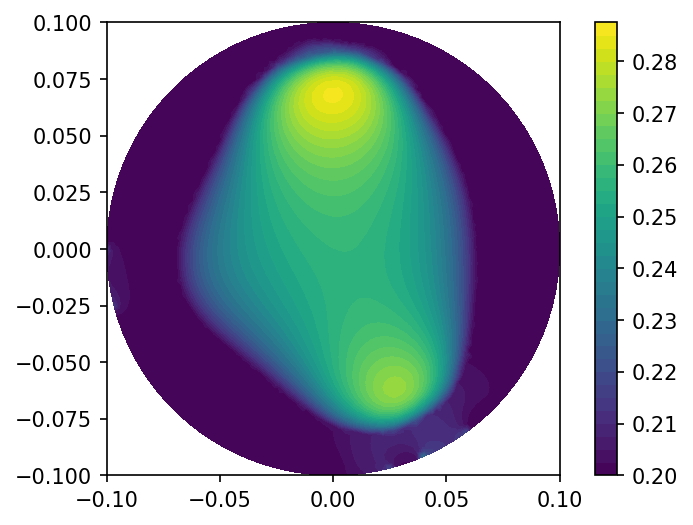

##############
              
Iteration  15
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

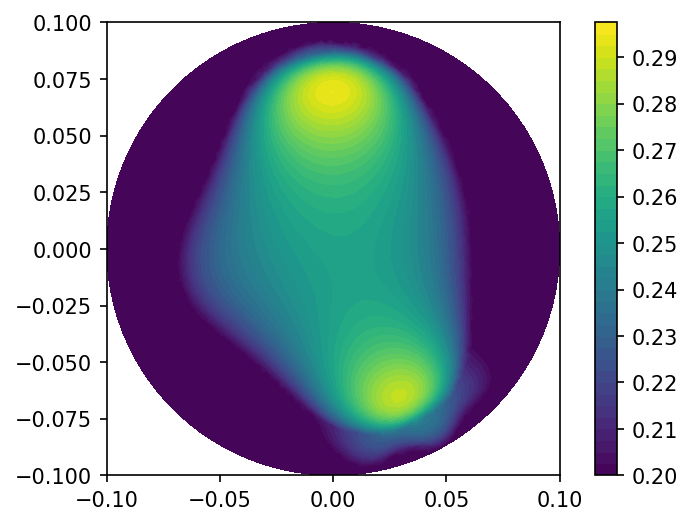

##############
              
Iteration  16
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

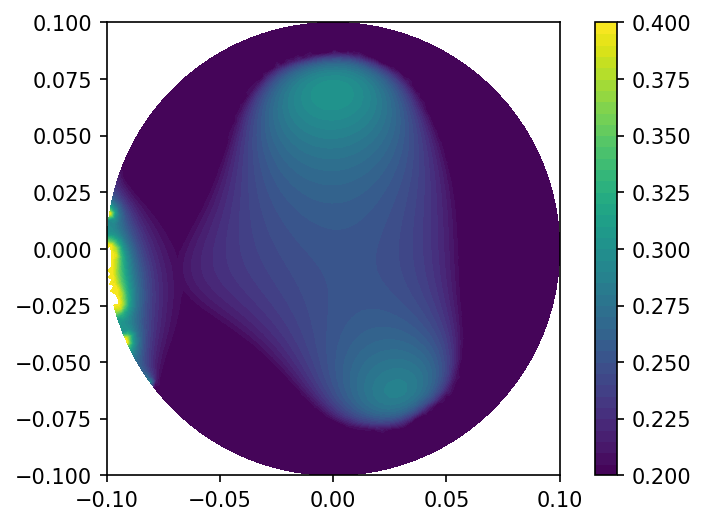

##############
              
Iteration  17
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

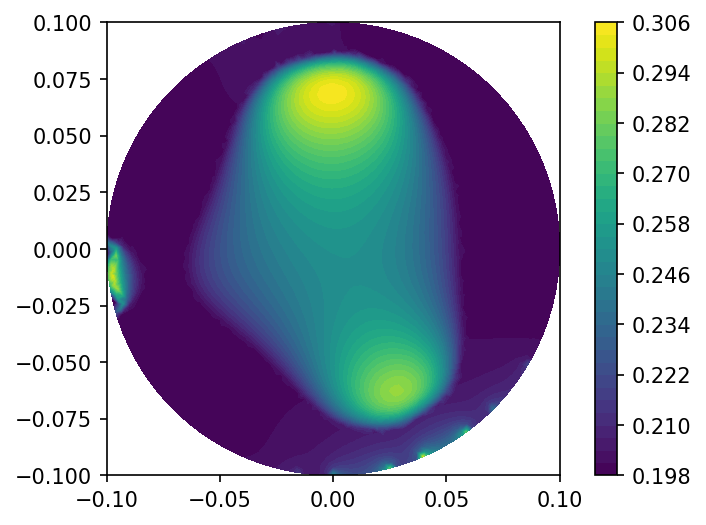

##############
              
Iteration  18
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

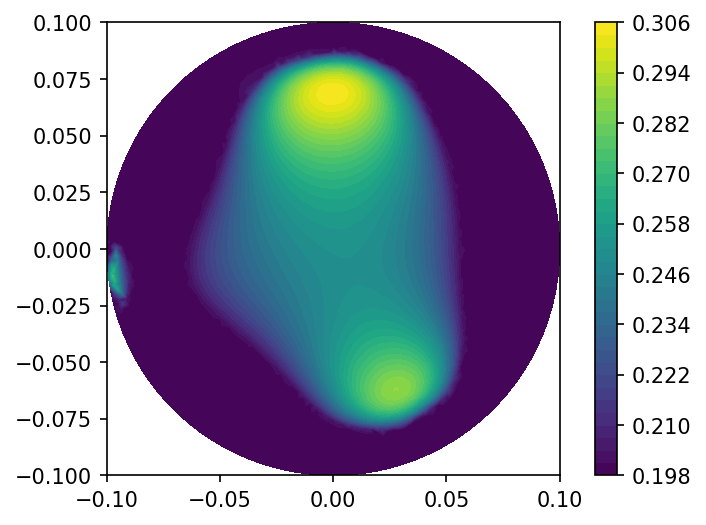

##############
              
Iteration  19
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

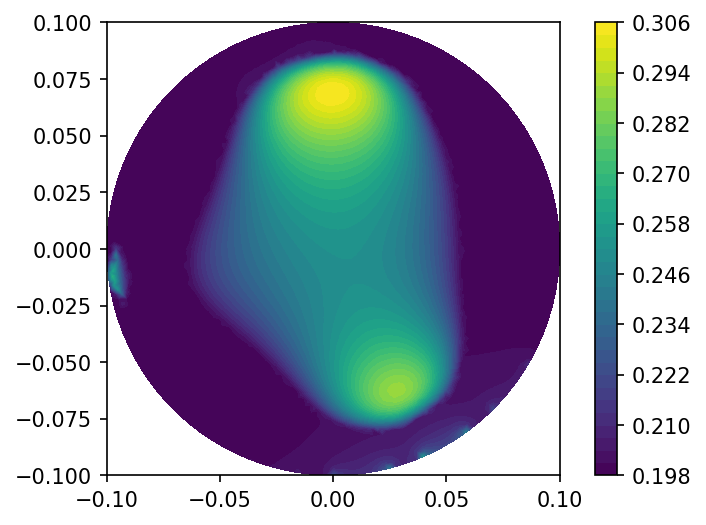

##############
              
Iteration  20
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

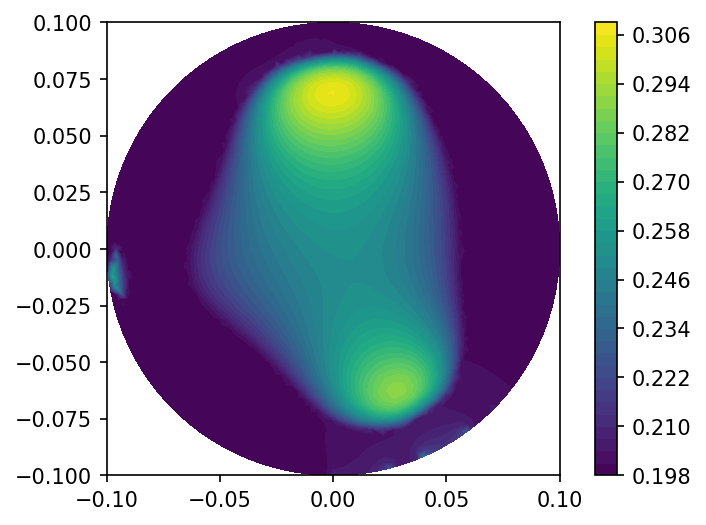

##############
              
Iteration  21
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

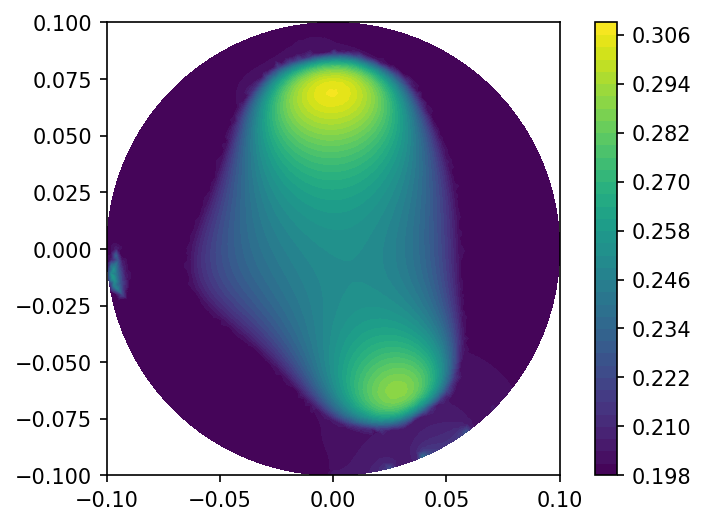

##############
              
Iteration  22
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

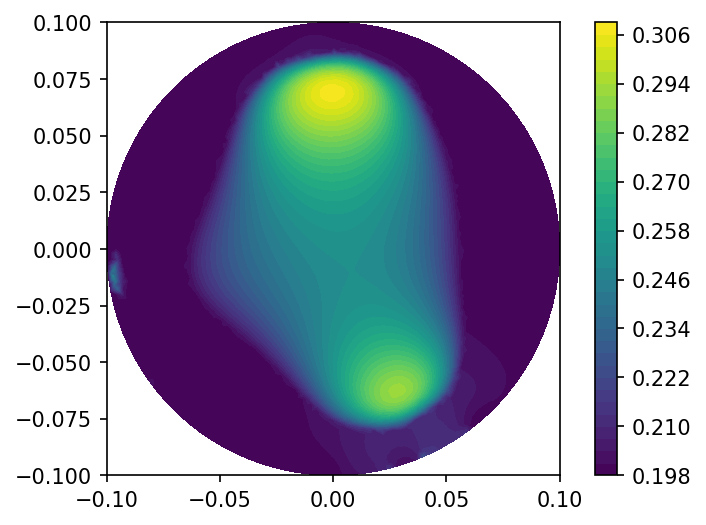

##############
              
Iteration  23
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

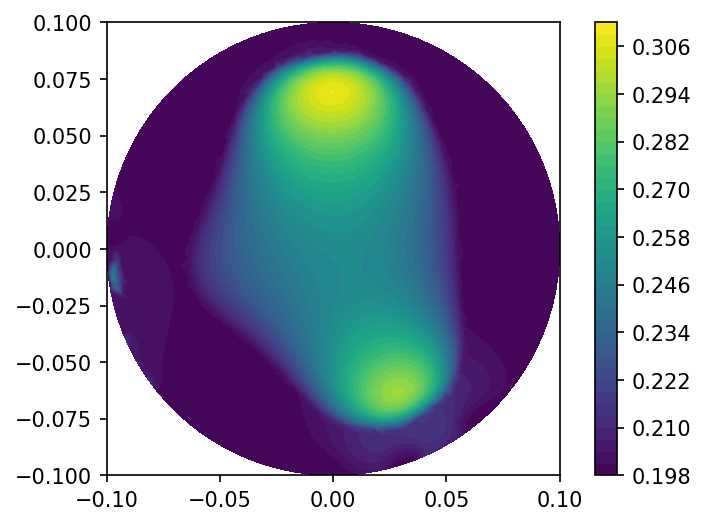

##############
              
Iteration  24
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

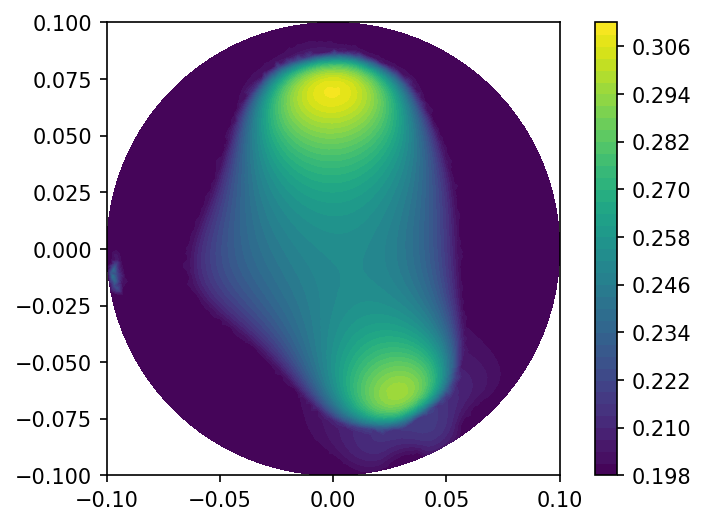

##############
              
Iteration  25
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

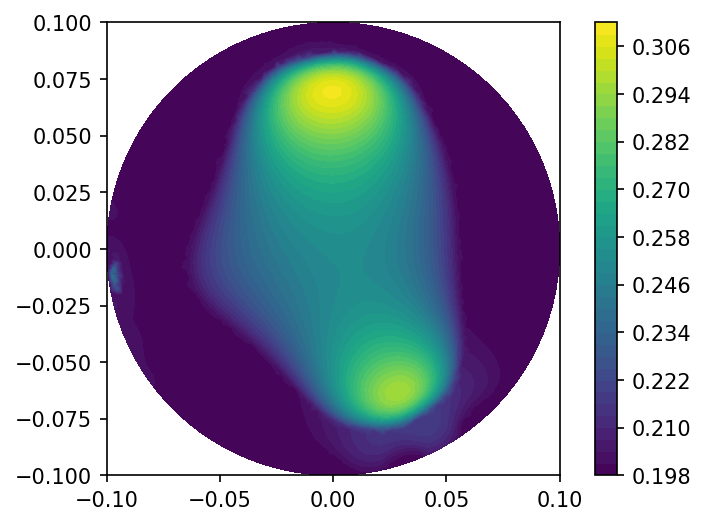

##############
              
Iteration  26
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

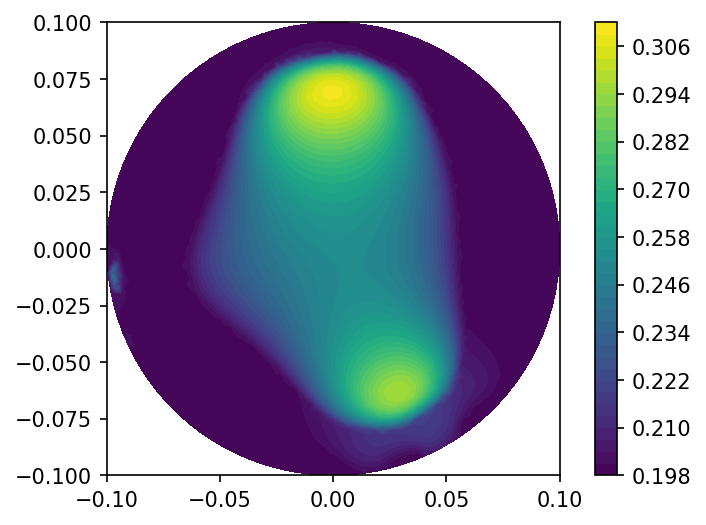

##############
              
Iteration  27
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

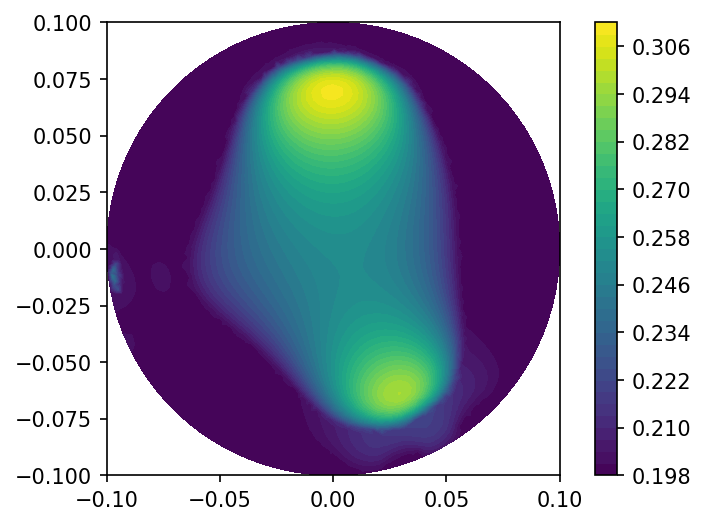

##############
              
Iteration  28
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

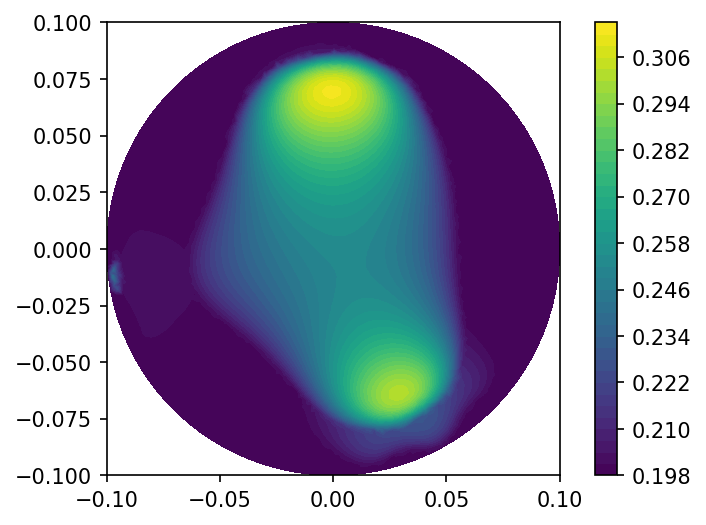

##############
              
Iteration  29
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

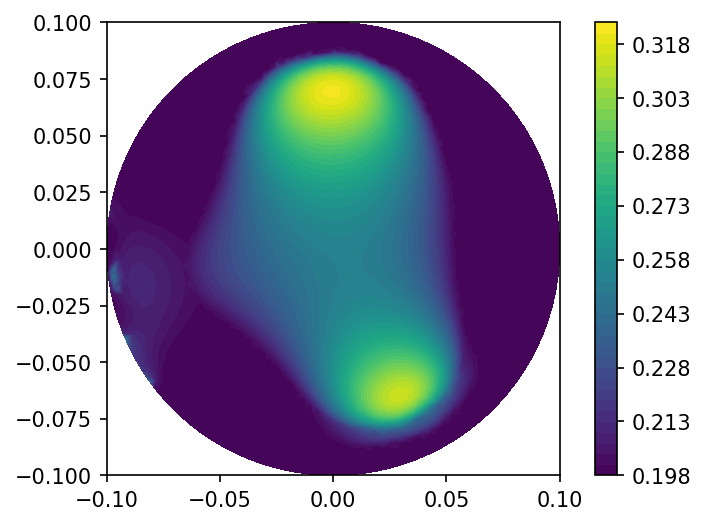

##############
              
Iteration  30
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

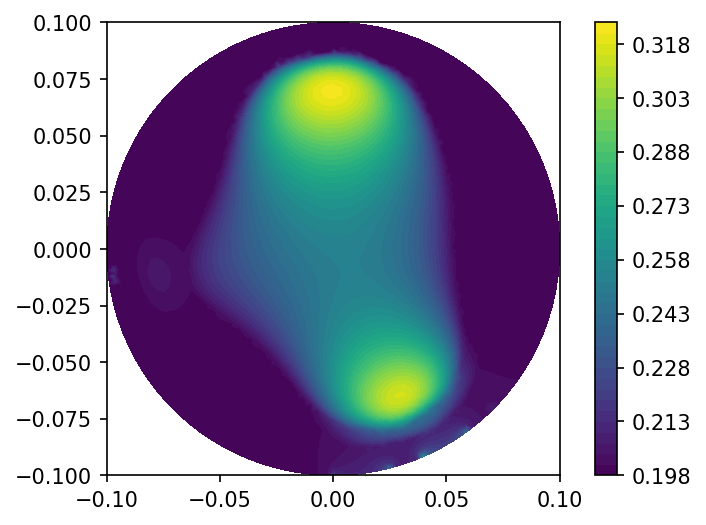

##############
              
Iteration  31
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

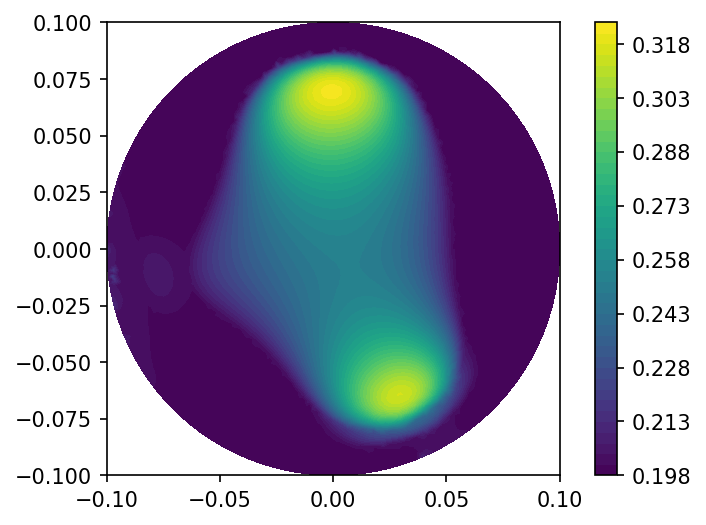

##############
              
Iteration  32
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

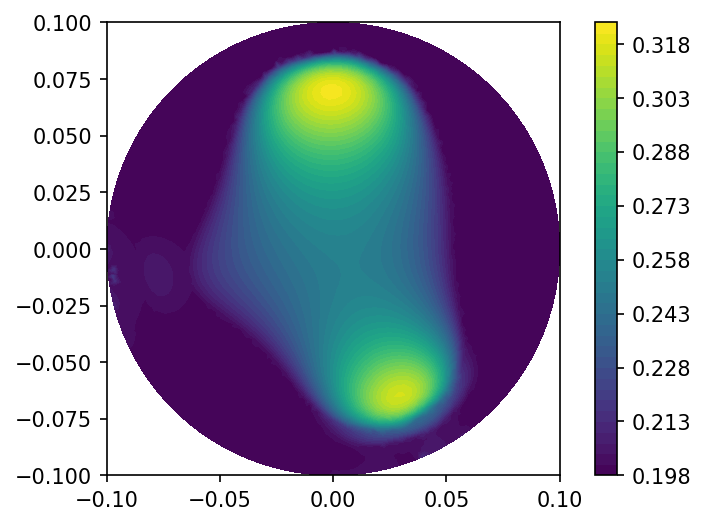

##############
              
Iteration  33
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

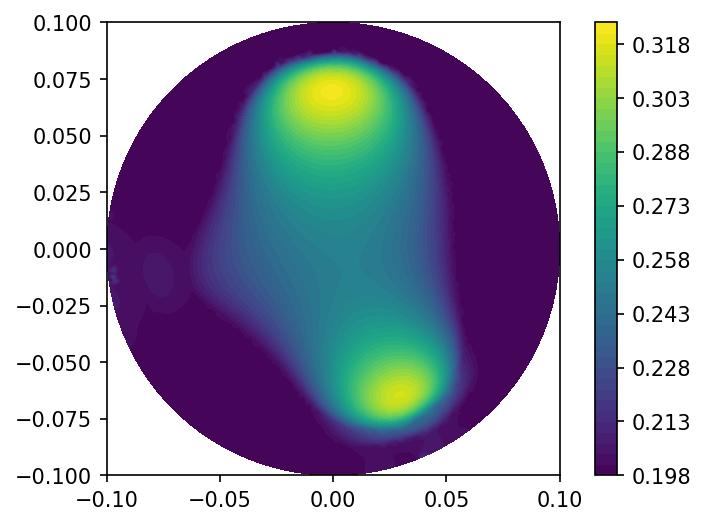

##############
              
Iteration  34
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

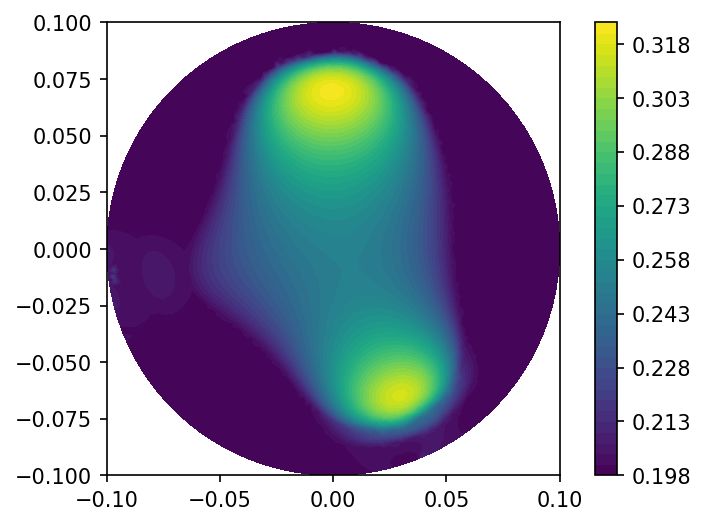

##############
              
Iteration  35
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

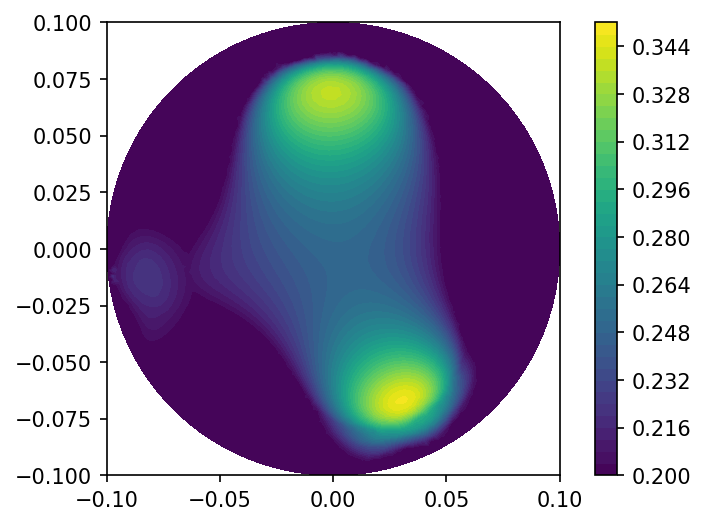

##############
              
Iteration  36
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

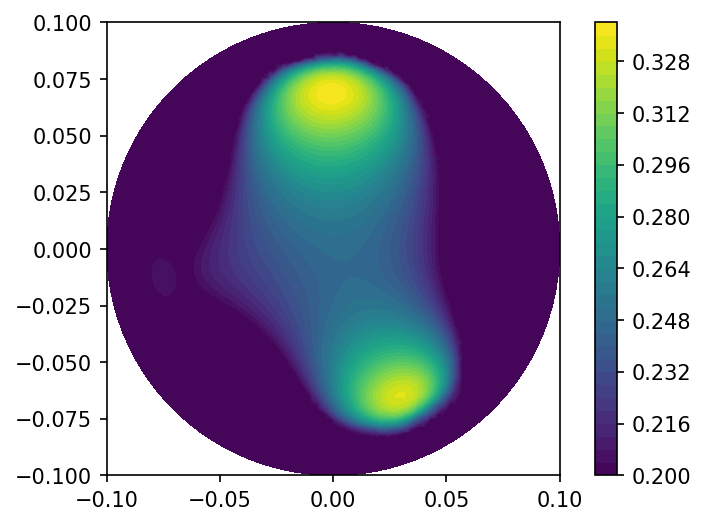

##############
              
Iteration  37
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

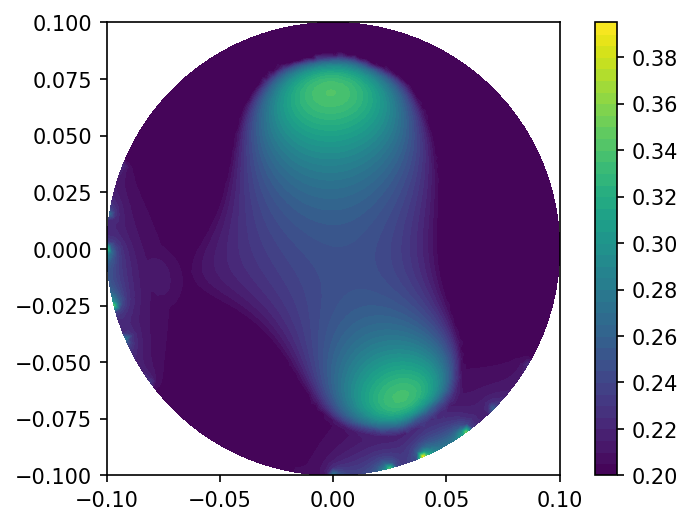

##############
              
Iteration  38
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

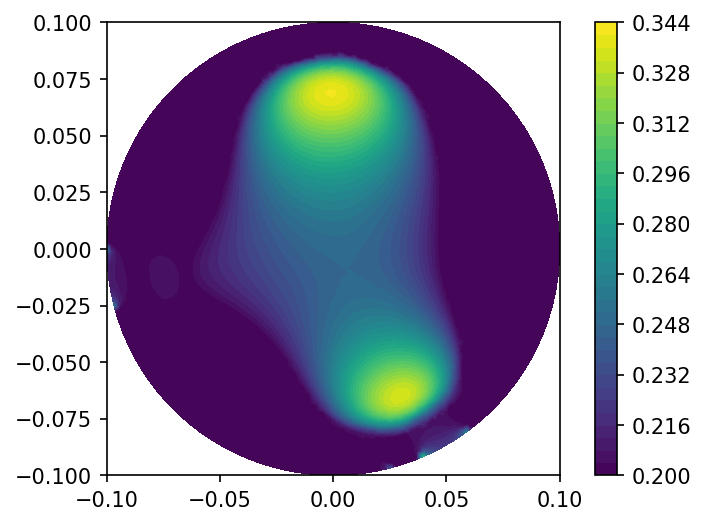

##############
              
Iteration  39
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

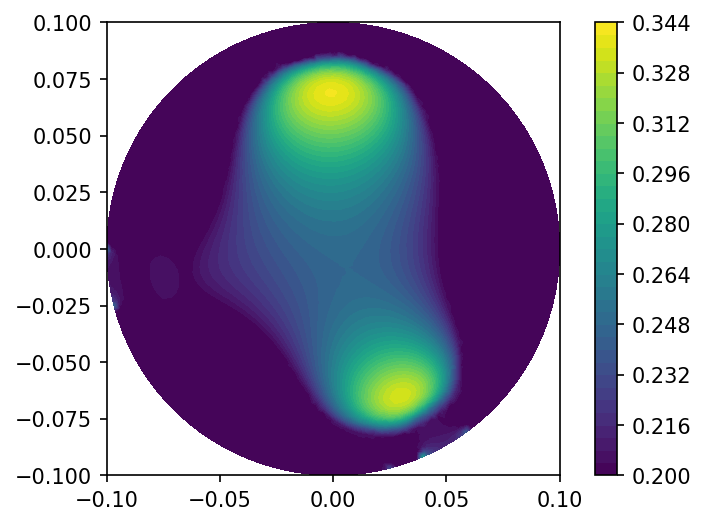

##############
              
Iteration  40
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

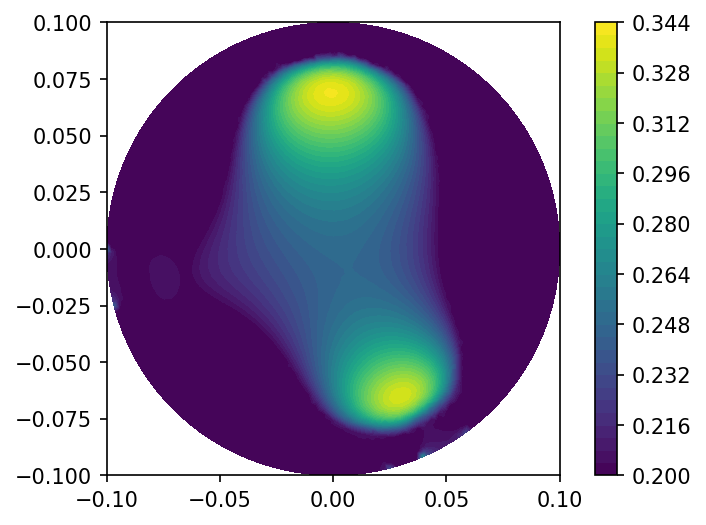

##############
              
Iteration  41
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

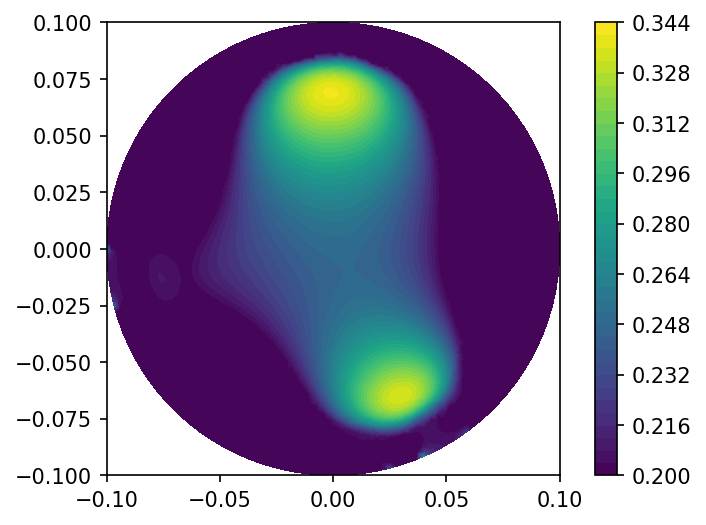

##############
              
Iteration  42
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

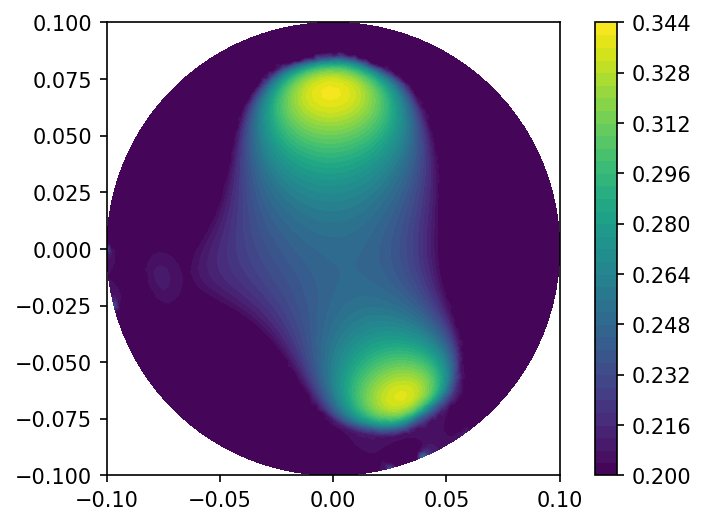

##############
              
Iteration  43
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

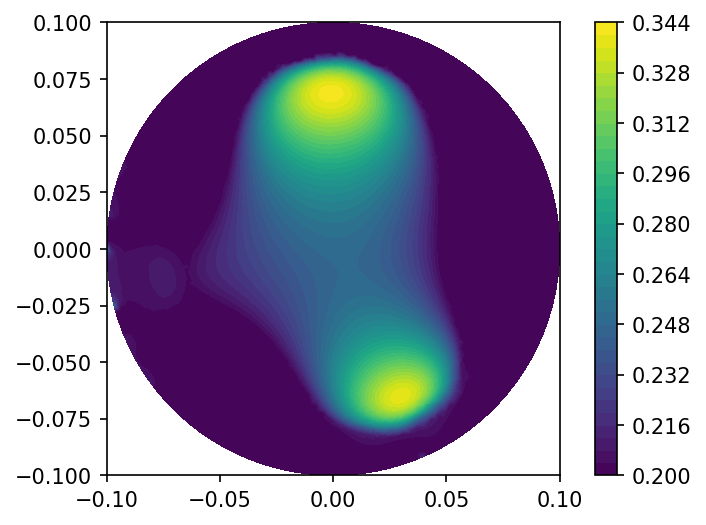

##############
              
Iteration  44
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

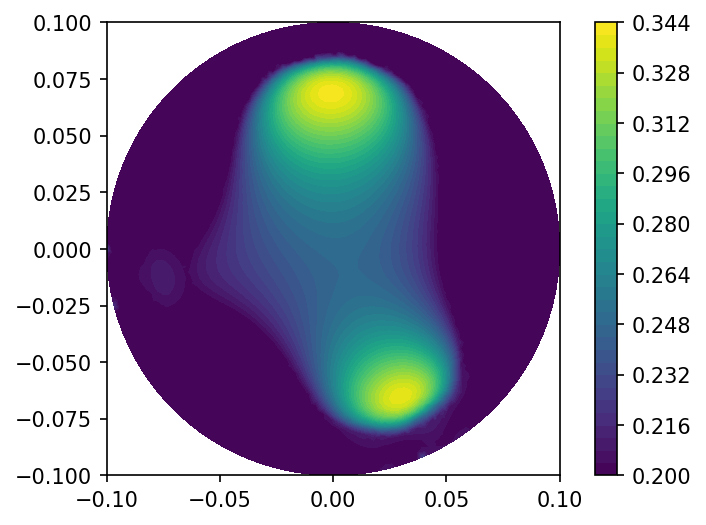

##############
              
Iteration  45
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

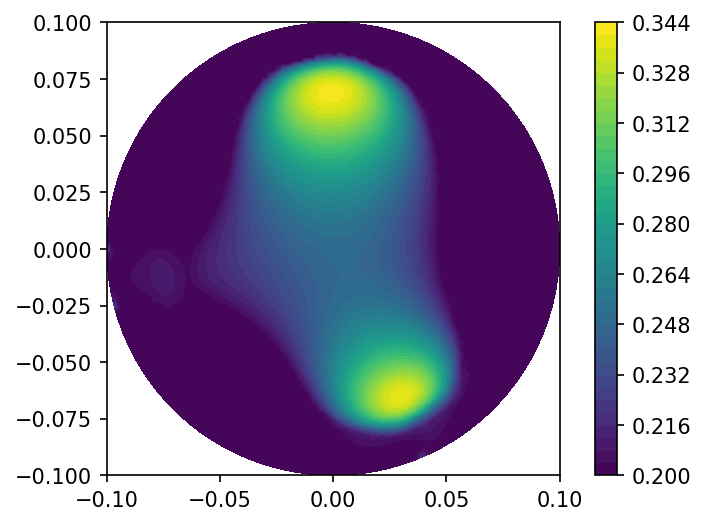

##############
              
Iteration  46
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

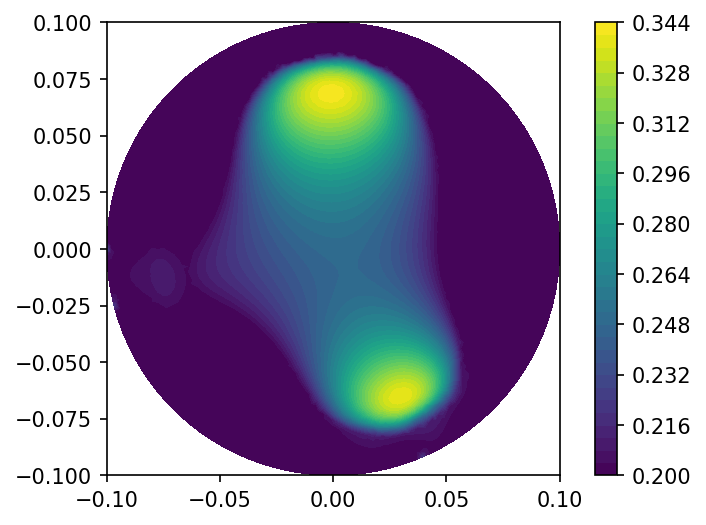

##############
              
Iteration  47
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

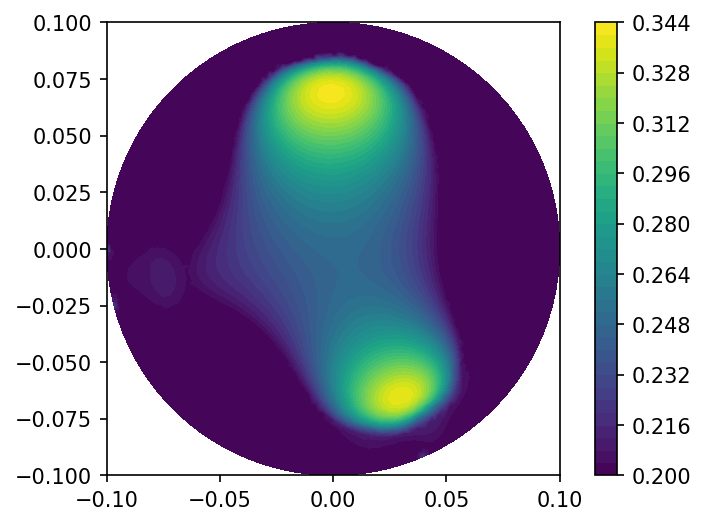

##############
              
Iteration  48
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

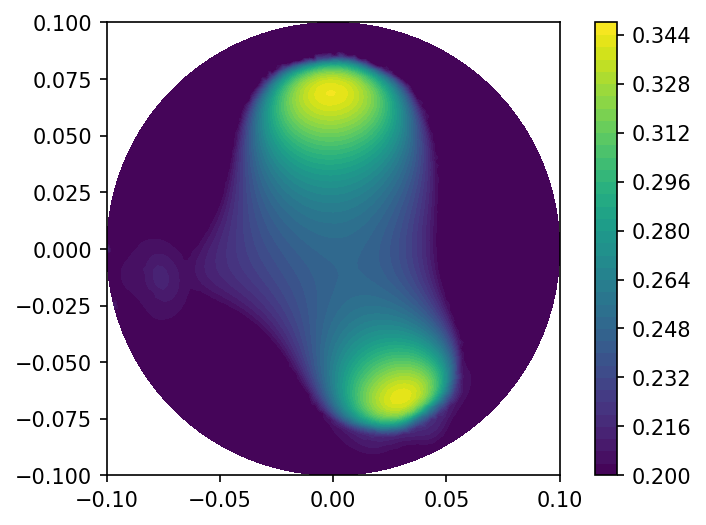

##############
              
Iteration  49
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compiler, this may take some time.
                Calling FFC just-in-time (JIT) compile

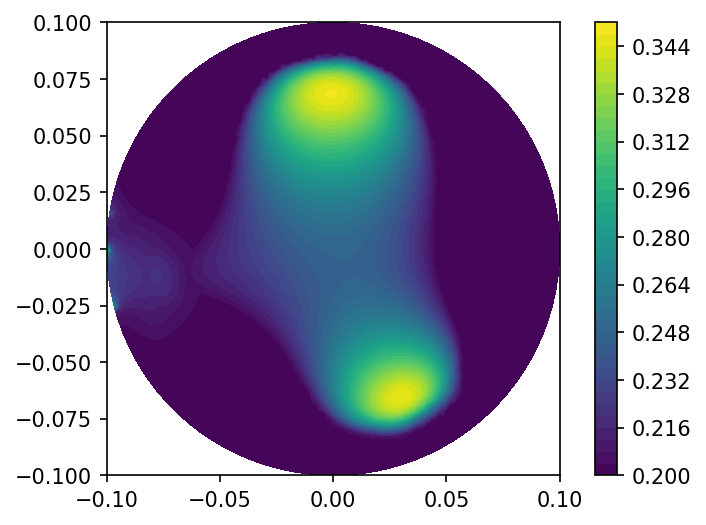

##############
              


In [936]:
## Main code for stage 3

eps = 1e-6
Nmax = 50
alpha_0 = 0.02

# Step 1
N = 0
U_N = []
for k in range(num_electrodes):
    U_N.append(U_star[k])
sigma_N = project(Constant(0.3),V)
alpha_N = alpha_0

e = np.eye(num_electrodes)
K_history = []
U_history3 = []

K_best = 1
sigma_best = sigma_N
                  


while N < Nmax:
    
    print("Iteration ", N)
    
    w_N = []

    # step 2
    U_N_j = get_U_j(U_N)
    u_N_j = get_u_j(sigma_N, U_N_j)
    K_N = K(u_N_j, U_N_j)
    
    K_history.append(K_N)
    U_history3.append(np.array(U_N))
    
    print("step 2 done")
    
    # step 3
    
    if N > 0:
        step_K = abs(K_N - K_N_minus_one)/K_N_minus_one
        step_sigma = L2_norm(sigma_N - sigma_N_minus_one) / L2_norm(sigma_N_minus_one)
        step_U = magnitude(subtract(U_N, U_N_minus_one))/magnitude(U_N_minus_one)
        
        if step_K < eps or step_sigma < eps or step_sigma < eps:
            print("Done!")
            break
    print("step 3 done")
    
    # step 4
    
    for k in range(num_electrodes):
        w_N.append(potential(sigma_N, e[k]))
        
    print("step 4 done")
    
    # step 5
    
    psi_N_j = get_psi_j(sigma_N, U_N_j, u_N_j, I_j)
    
    print("step 5 done")
    
    if N>0:
        grad_K_N = grad_K(w_N, psi_N_j, u_N_j, U_N_j, I_j)
        grad_K_N_minus_one = grad_K(w_N_minus_one,
                                    psi_N_minus_one_j, u_N_minus_one_j, U_N_minus_one_j, I_j)
        
        alpha_N = BBL_learning_rate(sigma_N, sigma_N_minus_one, U_N,
                      U_N_minus_one, grad_K_N, grad_K_N_minus_one)
    
    # step 6
    
    U_N_plus_one = [0]*num_electrodes
    
#    if N > 0 and K_N > K_N_minus_one:
#        alpha_N = alpha_N / 1.5
#    elif N > 0 and K_N_minus_one > K_N:
#        alpha_N = 1.1 * alpha_N
    
    sigma_N_plus_one = sigma_N    
    for j in range(num_electrodes):
        sigma_N_plus_one += alpha_N * inner(nabla_grad(psi_N_j[j]), nabla_grad(u_N_j[j]))
    sigma_N_plus_one = project(sigma_N_plus_one, V)
    
    for k in range(num_electrodes):
        U_N_plus_one[k] = U_N[k] - 2 * alpha_N * beta * (U_N[k] - U_star[k])
    
        for l in range(num_electrodes):
            for j in range(num_electrodes):
                U_N_plus_one[k] -=  alpha_N * 2 * (integrate_electrode(lambda x,y: (1/Z[l]) * (U_N_j[j][l] 
                                - u_N_j[j](x, y)), l) - I_j[j][l]) * integrate_electrode(lambda x,y:
                                   (1/Z[l]) * ((l==theta_kj(k,j)) - w_N[theta_kj(k,j)](x,y)), l)
                
    print("step 6 done")
    
    # step 7
    U_sum = sum(U_N_plus_one)

    for k in range(num_electrodes):
        U_N_plus_one[k] = U_N_plus_one[k] - (1/num_electrodes) * U_sum
        
    x = sigma_N_plus_one.vector()[:]
    x[x>0.4] = 0.4
    x[x<0.2] = 0.2
    sigma_N_plus_one.vector()[:] = x

    print("step 7 done")
    
    p=plot(sigma_N_plus_one)
    plt.colorbar(p)
    plt.show()
    
    if K_N < K_best:
        K_best = K_N
        sigma_best = sigma_N
    
    U_N_minus_one = [0]*num_electrodes
    
    for l in range(num_electrodes):
        U_N_minus_one[l] = U_N[l]
        U_N[l] = U_N_plus_one[l]
    
    K_N_minus_one = K_N
    sigma_N_minus_one = sigma_N
    sigma_N = sigma_N_plus_one
    
    u_N_minus_one_j = u_N_j
    psi_N_minus_one_j = psi_N_j
    U_N_minus_one_j = get_U_j(U_N_minus_one)
    
    w_N_minus_one = []
    for k in range(num_electrodes):
        w_N_minus_one.append(w_N[k])
        
    
    N += 1
    
    print("##############")
    print("              ")
    

    

    
    
    
    
    
    



   


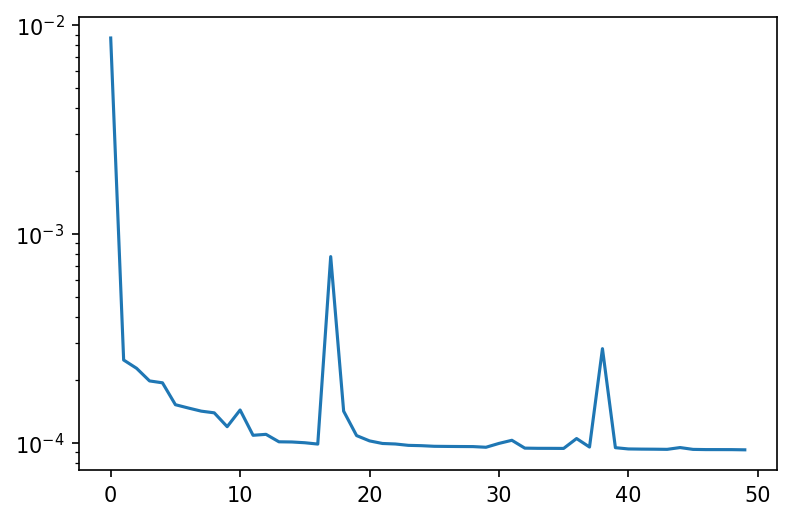

In [939]:
plt.plot(range(len(K_history)), K_history)
plt.yscale('log')

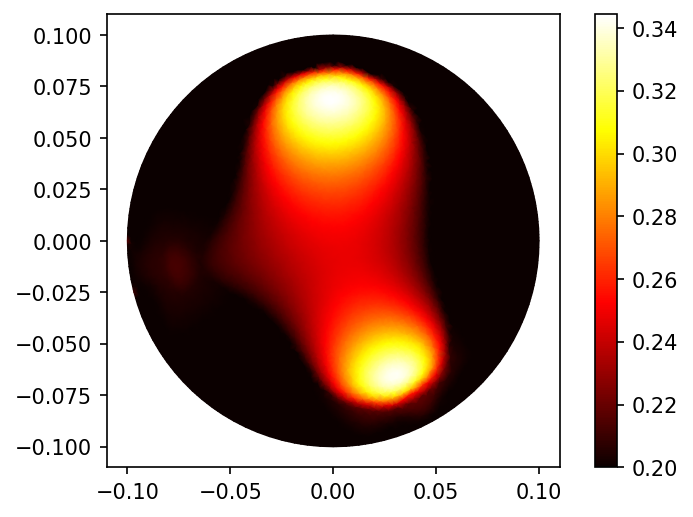

In [983]:
p = plot(sigma_best, mode='color', cmap='hot')
plt.colorbar(p)
plt.savefig("S3sigma.png")

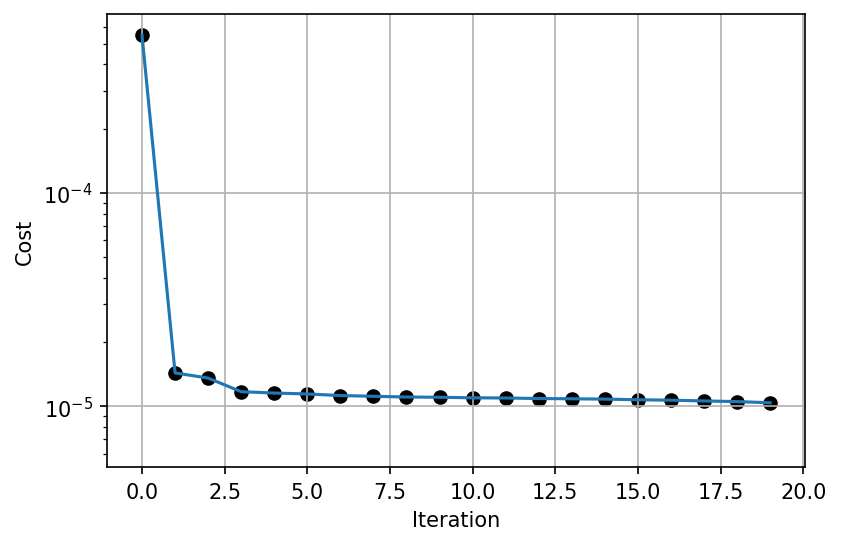

In [992]:
plt.plot(range(len(J_history2)), J_history2)
plt.scatter(range(len(J_history2)), J_history2, c='k')
plt.grid()
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.yscale('log')
plt.savefig("S2Cost.png")


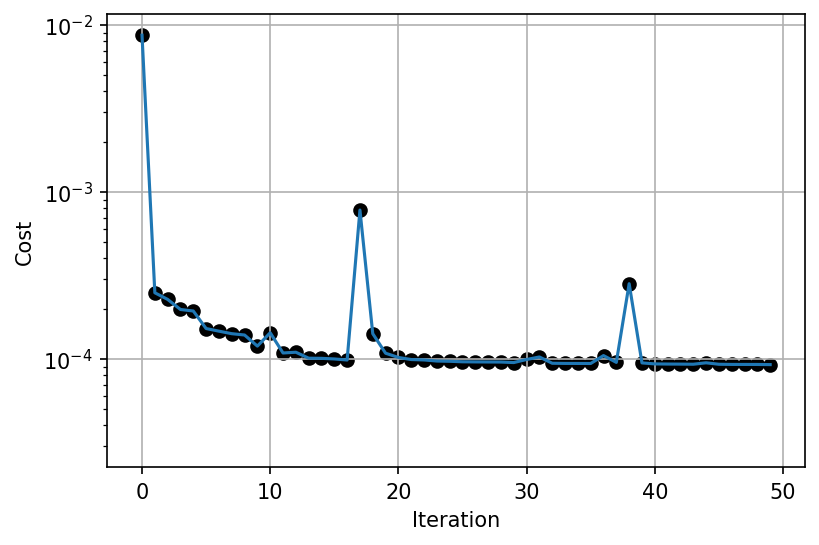

In [996]:
plt.plot(range(len(K_history)), K_history)
plt.scatter(range(len(K_history)), K_history, c='k')
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid()
plt.savefig("S3Cost.png")


